<a href="https://colab.research.google.com/github/SuzanneOngCodes/Semantic-segmentation/blob/main/Adam_%2B_ResNes50_%2B_FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ResNet50 + FCN backbone with the focus to test on performance betweeen different architectures**

In [ ]:
# Comment out %%capture to view downloading progress
%%capture

## If there is a problem in running the dataloader, try:
# !pip uninstall albumentations
## Restart runtime and continue
!pip install --upgrade albumentations

# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
# !pip uninstall segmentation_models.pytorch
!pip install segmentation-models-pytorch==0.2.0

In [ ]:
## Initial setup - removing redundant directory
## Average time to compute - approx. 1-2 mins
# Comment out %%capture to view downloading progress
%%capture
!rm -rf sample_data/

!pip install opencv-python-headless==4.5.2.52
# !pip install git+https://github.com/pytorch/pytorch.git
# !pip install torchmetrics

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 6.8 MB/s 


In [ ]:
# Comment out %%capture to view downloading progress
%%capture
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms
import shutil
from torch import nn
from tqdm.notebook import tqdm
import os
from PIL import Image
import pandas as pd
import cv2 as cv
import numpy as np
import albumentations as album
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torchvision
from torch.utils.data import DataLoader

# Import dataset here. 
**In this project, we will be starting off with RUGD offroad dataset from** http://rugd.vision

In [ ]:
# Comment out %%capture to view downloading progress
%%capture

if os.path.exists("/content/data") == False : 
  !mkdir data
  %cd data

  # Download and unzip raw frames from videos
  !wget http://rugd.vision/data/RUGD_frames-with-annotations.zip
  !unzip RUGD_frames-with-annotations.zip

  # Download and unzip raw annotations
  !wget http://rugd.vision/data/RUGD_annotations.zip
  !unzip RUGD_annotations.zip

  # Remove zip files
  !rm -r RUGD_annotations.zip
  !rm -r RUGD_frames-with-annotations.zip

  %mkdir "RUGD_frames-with-annotations"/training 
  %mkdir "RUGD_frames-with-annotations"/validation
  %mkdir "RUGD_frames-with-annotations"/testing
  %mkdir RUGD_annotations/training 
  %mkdir RUGD_annotations/validation
  %mkdir RUGD_annotations/testing

# Define labels based on classes

In [ ]:
id2label = {
    0: 'dirt',
    1: 'sand',
    2: 'grass',
    3: 'tree',
    4: 'pole',
    5: 'water',
    6: 'sky',
    7: 'vehicle',
    8: 'container/generic-object',
    9: 'asphalt',
    10: 'gravel',
    11: 'building',
    12: 'mulch',
    13: 'rock-bed',
    14: 'log',
    15: 'bicycle',
    16: 'person',
    17: 'fence',
    18: 'bush',
    19: 'sign',
    20: 'rock',
    21: 'bridge',
    22: 'concrete', 
    23: 'picnic-table'
 }

id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

## Check if there are 24 labels
num_labels = len(id2label)
print(num_labels)
CLASSES = ["dirt", "sand", "grass", "tree", "pole", "water", "sky", 
        "vehicle", "container/generic-object", "asphalt", "gravel", 
        "building", "mulch", "rock-bed", "log", "bicycle", "person", 
        "fence", "bush", "sign", "rock", "bridge", "concrete", "picnic-table"]

COLORMAP = [[ 108, 64, 20 ], [ 255, 229, 204 ],[ 0, 102, 0 ],[ 0, 255, 0 ],
            [ 0, 153, 153 ],[ 0, 128, 255 ],[ 0, 0, 255 ],[ 255, 255, 0 ],[ 255, 0, 127 ],
            [ 64, 64, 64 ],[ 255, 128, 0 ],[ 255, 0, 0 ],[ 153, 76, 0 ],[ 102, 102, 0 ],
            [ 102, 0, 0 ],[ 0, 255, 128 ],[ 204, 153, 255 ],[ 102, 0, 204 ],[ 255, 153, 204 ],
            [ 0, 102, 102 ],[ 153, 204, 255 ],[ 102, 255, 255 ],[ 101, 101, 11 ],[ 114, 85, 47 ] ]

color_id = {tuple(c):i for i, c in enumerate(COLORMAP)}

select_class_indices = [CLASSES.index(cls.lower()) for cls in CLASSES]
select_class_rgb_values =  np.array(COLORMAP)[select_class_indices]

24


# **Data Preprocessing**

In [ ]:
# Resize width and height
def get_augmentation():
    train_transform = [
        album.Resize(304, 304),
        album.PadIfNeeded(min_height=100, min_width=100, always_apply=True, border_mode=0),
        album.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.5,
        ),
    ]
    return album.Compose(train_transform)

def get_validation_augmentation():
    train_transform = [
        album.Resize(304, 304),
        album.PadIfNeeded(min_height=100, min_width=100, always_apply=True, border_mode=0),
    ]
    return album.Compose(train_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

In [ ]:
# Helper function to visualize on a sample image 
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

# classes for data loading and preprocessing
class SemanticSegmentationDataset():

    def __init__(self, root_dir, train, colormap = select_class_rgb_values, augmentation = None, preprocessing=None):
        
        self.root_dir = root_dir
        self.train = train
        self.colormap = colormap
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        self.img_dir = os.path.join(self.root_dir, "RUGD_frames-with-annotations")
        self.ann_dir = os.path.join(self.root_dir, "RUGD_annotations")
        
        # read images and allocate them to training, validation and testing sets 
        sub_train = ["creek", "park-1", "park-2", "trail-4", "trail-11","trail-12","trail-13","trail-14", "trail-5", "trail-6"]
        sub_valid = ["trail-7","trail-9", "village"]
        sub_test = ["trail-15", "trail-3", "park-8","trail","trail-10"]

        places = []
        subpath = ""
        if self.train==1:
          places = sub_train
          subpath = "training"
        elif self.train == 2:
          places = sub_test
          subpath = "testing"
        else:
          places = sub_valid
          subpath = "validation"

        image_file_names = [] 
        annotation_file_names = []
        self.img_directory = os.path.join(self.img_dir, subpath)
        self.ann_directory = os.path.join(self.ann_dir, subpath)

        for i in places:
          source_dir = os.path.join(self.img_dir, i)
          source_a_dir = os.path.join(self.ann_dir, i)

          for j in os.listdir(source_dir):
            shutil.copy(os.path.join(source_dir,j), self.img_directory) ## Or shutil.set to save memory

          for j in os.listdir(source_a_dir):
            shutil.copy(os.path.join(source_a_dir,j), self.ann_directory)
          

        ## Make sure that all frames matches with the assigned annotations
        for root, dirs, files in os.walk(self.img_directory):
          image_file_names.extend(files)
          annotation_file_names.extend(files)
          
        self.images = sorted(image_file_names)
        self.annotations = sorted(annotation_file_names)
        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv.cvtColor(cv.imread(os.path.join(self.img_directory,self.images[idx])), cv.COLOR_BGR2RGB)
        mask = cv.cvtColor(cv.imread(os.path.join(self.ann_directory,self.annotations[idx])), cv.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.colormap).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask

# Check the dataset

In [ ]:
# Get all information on the training, testing and validation sets
# train_set = SemanticSegmentationDataset(root_dir="/content/data", train = 1)
# test_set = SemanticSegmentationDataset(root_dir="/content/data", train = 2)
val_set = SemanticSegmentationDataset(root_dir="/content/data", train = 3)

In [ ]:
## Length of all sets
# print("Number of training examples:", len(train_set))
print("Number of validation examples:", len(val_set))
# print("Number of testing examples:", len(test_set))

Number of validation examples: 465


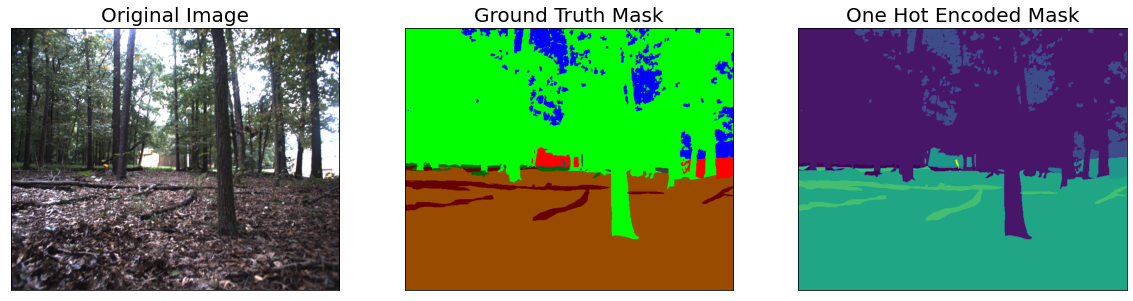

(550, 688)

In [ ]:
# Check format
random_idx = np.random.randint(0, len(val_set)-1)
image, mask = val_set[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)
reverse_one_hot(mask).shape

# Establish architecture

In [ ]:
from torchvision import models

fcn = models.segmentation.fcn_resnet50(pretrained=0, progress=1, num_classes=len(CLASSES))

class SegModel(nn.Module):
    def __init__(self):
        super(SegModel,self).__init__()
        self.dl = fcn
        
    def forward(self, x):
        y = self.dl(x)['out']
        return y

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
import segmentation_models_pytorch as smp

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' 

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# Estabish model and optimizer

---



In [ ]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
from torch.nn import functional as F

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SegModel()

# define loss function
loss = nn.BCEWithLogitsLoss()

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer, gamma=0.001,
)

model.to(DEVICE)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/best_modelFCNAdam.pth'):
    model = torch.load('/content/drive/MyDrive/Colab Notebooks/best_modelFCNAdam.pth', map_location=DEVICE)


In [ ]:
## Add metrics
from torchmetrics import F1Score, Precision, Recall
from sklearn.metrics import precision_score, multilabel_confusion_matrix

def meanIOU(target, predicted):
    if target.shape != predicted.shape:
        print("target has dimension", target.shape, ", predicted values have shape", predicted.shape)
        return
        
    if target.dim() != 4:
        print("target has dim", target.dim(), ", Must be 4.")
        return
    
    iousum = 0
    for i in range(target.shape[0]):
        target_arr = target[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        predicted_arr = predicted[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        
        intersection = np.logical_and(target_arr, predicted_arr).sum()
        union = np.logical_or(target_arr, predicted_arr).sum()
        if union == 0:
            iou_score = 0
        else :
            iou_score = intersection / union
        iousum +=iou_score
        
    miou = iousum/target.shape[0]
    return miou

def pixelAcc(target, predicted):    
    if target.shape != predicted.shape:
        print("target has dimension", target.shape, ", predicted values have shape", predicted.shape)
        return
        
    if target.dim() != 4:
        print("target has dim", target.dim(), ", Must be 4.")
        return
    
    accsum=0
    for i in range(target.shape[0]):
        target_arr = target[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        predicted_arr = predicted[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        
        same = (target_arr == predicted_arr).sum()
        a, b = target_arr.shape
        total = a*b
        accsum += same/total
    
    pixelAccuracy = accsum/target.shape[0]        
    return pixelAccuracy

In [ ]:
def training_loop(n_epochs, optimizer, lr_scheduler, model, loss_fn, val_loader, train_loader = None, lastCkptPath = None):
    if torch.cuda.is_available():  
        dev = "cuda:0" 
    else:  
        dev = "cpu"
    device = torch.device(dev)
    
    tr_loss_arr = []
    val_loss_arr = []
    meanioutrain = []
    pixelacctrain = []
    meanioutest = []
    pixelacctest = []
    f1train = []
    f1test = []
    precisiontrain = []
    precisiontest = []
    recalltrain = []
    recalltest = []
    prevEpoch = 0
    
    if lastCkptPath != None :
        checkpoint = torch.load(lastCkptPath)
        prevEpoch = checkpoint['epoch']
        try:
          checkpoint.eval()
        except AttributeError as error:
          print(error)
        model = SegModel() 
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict']) 
        for state in optimizer.state.values():
          for k, v in state.items():
            if isinstance(v, torch.Tensor):
              state[k] = v.to(device).tr_loss_arr =  checkpoint['Training Loss']
        val_loss_arr =  checkpoint['Validation Loss']
        meanioutrain =  checkpoint['MeanIOU train']
        pixelacctrain =  checkpoint['PixelAcc train']
        meanioutest =  checkpoint['MeanIOU test']
        pixelacctest =  checkpoint['PixelAcc test']
        # precisiontrain = checkpoint['Precision Train']
        # precisiontest = checkpoint['Precision Test']
        # recalltrain = checkpoint['Recall Train']
        # recalltest = checkpoint['Recall Test']
        # f1train = checkpoint['F1 score Train']
        # f1test = checkpoint['F1 score Test'] 

        print("loaded model at epoch", prevEpoch)
        model.to(device)
    
    for epoch in range(0, n_epochs):
        if train_loader != None:
          train_loss = 0.0
          pixelacc = 0
          meaniou = 0
          
          pbar = tqdm(train_loader, total = len(train_loader))
          for X, y in pbar:
              torch.cuda.empty_cache()
              model.train()
              X = X.to(device).float()
              y = y.to(device).float()
              ypred = model(X)
              loss = loss_fn(ypred, y)
              
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              
              tr_loss_arr.append(loss.item())
              meanioutrain.append(meanIOU(y, ypred))
              pixelacctrain.append(pixelAcc(y, ypred))
              # precisiontrain.append(precision(y, ypred))
              # recalltrain.append(recall(y, ypred))
              # f1train.append(f1(y, ypred))
              pbar.set_postfix({'Epoch':epoch+1+prevEpoch, 
                                'Training Loss': np.mean(tr_loss_arr),
                                'Mean IOU': np.mean(meanioutrain),
                                'Pixel Acc': np.mean(pixelacctrain),
                                # 'Precision': np.mean(precisiontrain),
                                # 'Recall':np.mean(recalltrain),
                                # 'F1 Score':np.mean(f1train)
                              })
            
        with torch.no_grad():
            
            val_loss = 0
            pbar = tqdm(val_loader, total = len(val_loader))
            for X, y in pbar:
                torch.cuda.empty_cache()
                X = X.to(device).float()
                y = y.to(device).float()
                model.eval()
                ypred = model(X)
                
                val_loss_arr.append(loss_fn(ypred, y).item())
                pixelacctest.append(pixelAcc(y, ypred))
                meanioutest.append(meanIOU(y, ypred))
                # precisiontest.append(precision(y, ypred))
                # recalltest.append(recall(y, ypred))
                # f1test.append(f1(y, ypred))
                
                pbar.set_postfix({'Epoch':epoch+1+prevEpoch, 
                                  'Validation Loss': np.mean(val_loss_arr),
                                  'Mean IOU': np.mean(meanioutest),
                                  'Pixel Acc': np.mean(pixelacctest),
                                  # 'Precision': np.mean(precisiontest),
                                  # 'Recall':np.mean(recalltest),
                                  # 'F1 Score':np.mean(f1test)
                                 })
        
        
        
        checkpoint = {
            'epoch':epoch+1+prevEpoch,
            'state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'Training Loss': tr_loss_arr,
            'Validation Loss':val_loss_arr,
            'MeanIOU train':meanioutrain, 
            'PixelAcc train':pixelacctrain, 
            'MeanIOU test':meanioutest, 
            'PixelAcc test':pixelacctest,
            # 'Precision Train': precisiontrain, 
            # 'Precision Test': precisiontest, 
            # 'Recall Train': recalltrain, 
            # 'Recall Test': recalltest, 
            # 'F1 score Train': f1train, 
            # 'F1 score Test': f1test, 
        }
        torch.save(checkpoint, '/content/best_modelFCNAdam.pth')
        lr_scheduler.step()
        
    return np.mean(tr_loss_arr),np.mean(val_loss_arr),np.mean(meanioutrain),np.mean(pixelacctrain), np.mean(meanioutest), np.mean(pixelacctest) #, f1train, f1test, precisiontrain, precisiontest, recalltrain ,recalltest

# Get epochs and augmented datasets for training and validation sets

In [ ]:
# import albumentations
# Get train and val dataset instances
train_dataset = SemanticSegmentationDataset(
    root_dir='/content/data', 
    train = 1,
    augmentation = get_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn)
)

valid_dataset = SemanticSegmentationDataset(
    root_dir = '/content/data', 
    train=3,
    augmentation = get_validation_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn)
)

# Dataloaders

In [ ]:
# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=20, shuffle=False, num_workers=0, pin_memory=True)

# **Train the model**
When tested in range 1-25, the optimal so far is 3 epochs, but feel free to adjust the number at EPOCHS in line 12

In [ ]:
%%time
retval = training_loop(5, 
                       optimizer, 
                       lr_scheduler, 
                       model, 
                       loss,  
                       valid_loader,
                       train_loader)

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

CPU times: user 3h 19min 15s, sys: 17min 12s, total: 3h 36min 27s
Wall time: 3h 35min 43s


In [ ]:
# load best saved model checkpoint from the current run
ckp = ""
if os.path.exists('/content/best_modelFCNAdam.pth'):
    model = torch.load('/content/best_modelFCNAdam.pth', map_location=DEVICE)
    ckp = '/content/best_modelFCNAdam.pth'
    print('Loaded FCN + Adam model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('/content/drive/MyDrive/Colab Notebooks/best_modelFCNAdam.pth'):
    model = torch.load('/content/drive/MyDrive/Colab Notebooks/best_modelFCNAdam.pth', map_location=DEVICE)
    ckp = '/content/drive/MyDrive/Colab Notebooks/best_modelFCNAdam.pth'
    print('Loaded FCN+Adam model from a previous commit.')

Loaded FCN + Adam model from this run.


# Run model on **testing set**

In [ ]:
preds_folder = '/content/predictionsFCNAdam/'
if not os.path.exists(preds_folder):
    os.makedirs("/content/predictionsFCNAdam/")

In [ ]:
test_dataset = SemanticSegmentationDataset(
    root_dir='/content/data', 
    train = 2,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=True, num_workers=0, pin_memory=True)

In [ ]:
# Testing
testmodel = SegModel() 
testmodel.to(DEVICE)
retval = training_loop(1, 
                       optimizer, 
                       lr_scheduler, 
                       model, 
                       loss, 
                       test_dataloader,
                       lastCkptPath=ckp)

testmodel.load_state_dict(model['state_dict'])
testmodel.to(DEVICE).float()
testmodel.eval()

'dict' object has no attribute 'eval'
loaded model at epoch 2


  0%|          | 0/101 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


SegModel(
  (dl): FCN(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReL

# **Inference, Metrics Evaluation and Visualisation**

In [ ]:
tr_loss_arr, val_loss_arr, meanioutrain, pixelacctrain, meanioutest, pixelacctest = retval
print("Evaluation on Test Data: ")
print(f"Mean Accuracy: {pixelacctest:.4f}")
print(f"Mean Loss: {val_loss_arr:.4f}")
print(f"Mean IoU Score: {meanioutest:.4f}")

Evaluation on Test Data: 
Mean Accuracy: 0.6120
Mean Loss: 0.9084
Mean IoU Score: 0.9764


In [ ]:
## For sample illustrations
# Center crop padded image / mask to original image dims
def crop_image(image, true_dimensions):
    return album.CenterCrop(p=1,height=304, width=304)(image=image)

# test dataset for visualization
test_dataset_vis = SemanticSegmentationDataset(
    root_dir='/content/data',
    train = 2,
    augmentation=get_validation_augmentation(),
)

In [ ]:
from random import randint

for idx in range(500):
    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    true_dimensions = image_vis.shape
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = testmodel(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    pred_mask = cv.resize(pred_mask,(304,304))

    # Get prediction channel corresponding to sky, or any classes available
    pred_foreground_heatmap = crop_image(pred_mask[:,:,CLASSES.index("sky")], true_dimensions)['image']
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values), true_dimensions)['image']
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values), true_dimensions)['image']
    cv.imwrite(os.path.join(preds_folder, f"pred_{idx}.png"), np.hstack([pred_mask])[::])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        pred_foreground_heatmap = pred_foreground_heatmap
    )
    

In [ ]:
## Copy all info:
with open('inferenceFCNAdam.txt', 'w') as convert_file:
  convert_file.write("\Test loss")
  convert_file.write(str(val_loss_arr))
  convert_file.write("\nMean IOU test")
  convert_file.write(str(meanioutest))
  convert_file.write("\nPixel accuracy test")
  convert_file.write(str(pixelacctest))

In [ ]:
## Download predictions and trained model
!zip -r /content/predictionsFCNAdam.zip /content/predictionsFCNAdam
from google.colab import files
files.download("/content/predictionsFCNAdam.zip")
files.download("/content/best_modelFCNAdam.pth")
files.download("/content/data/inferenceFCNAdam.txt")

  adding: content/predictionsFCNAdam/ (stored 0%)
  adding: content/predictionsFCNAdam/pred_19.png (deflated 45%)
  adding: content/predictionsFCNAdam/pred_447.png (deflated 23%)
  adding: content/predictionsFCNAdam/pred_348.png (deflated 13%)
  adding: content/predictionsFCNAdam/pred_197.png (deflated 31%)
  adding: content/predictionsFCNAdam/pred_155.png (deflated 36%)
  adding: content/predictionsFCNAdam/pred_46.png (deflated 23%)
  adding: content/predictionsFCNAdam/pred_398.png (deflated 35%)
  adding: content/predictionsFCNAdam/pred_206.png (deflated 20%)
  adding: content/predictionsFCNAdam/pred_156.png (deflated 41%)
  adding: content/predictionsFCNAdam/pred_458.png (deflated 18%)
  adding: content/predictionsFCNAdam/pred_449.png (deflated 25%)
  adding: content/predictionsFCNAdam/pred_43.png (deflated 40%)
  adding: content/predictionsFCNAdam/pred_408.png (deflated 14%)
  adding: content/predictionsFCNAdam/pred_309.png (deflated 39%)
  adding: content/predictionsFCNAdam/pred_3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>